In [ ]:
import copy
from pathlib import Path
import warnings
import holidays
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import gc
import tensorflow as tf 
# import tensorboard as tb 
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import holidays
import warnings
warnings.filterwarnings('ignore')


random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.manual_seed(30)
torch.cuda.manual_seed(30)

In [2]:
data = pd.read_excel('data22-23.xlsx')
data.drop('PTF (TL/MWh).1', axis = 1, inplace = True)
data

,Tarih,Teklif Edilen Satış Miktarı (MWh),Eşleşen Satış Miktarı (MWh),Pozitif Dengesizlik Miktarı (MWh),Negatif Dengesizlik Miktarı (MWh),Rüzgar Üretim ( TL/MWh),Güneş Üretim ( TL/MWh),Fiyat/Limit Oranı,İşlem Hacmi (TL),Azami Fiyat Limiti (TL/MWh),Teklif Edilen Alış Miktarı (MWh),PTF (TL/MWh),PTF (USD/MWh),Gerçekleşen Tüketim Miktarı(MWh),PTF (EUR/MWh),Eşleşen Alış Miktarı (MWh),Yük Tahmin Planı (MWh),Haftanın Günü,UEÇM (MWh)
0,2022-01-01 00:00:00,21455.4,18231.1,2572.81,-1221.32,1634.72,0.47,0.706305,17297080.13,1345,22281.6,949.98,73.20,31021.25,64.70,18231.1,35086,Cumartesi,28626.90
1,2022-01-01 01:00:00,21607.9,17573.5,1293.53,-1480.78,1689.69,1.19,0.594796,15360053.88,1345,21639.3,800.00,61.65,29710.69,54.49,17573.5,32574,Cumartesi,27343.17
2,2022-01-01 02:00:00,21863.4,16916.2,1336.46,-1693.26,1720.48,1.96,0.668387,15650926.01,1345,21272.3,898.98,69.27,28318.53,61.23,16916.2,31185,Cumartesi,25989.88
3,2022-01-01 03:00:00,21984.5,16267.3,1890.46,-1236.30,1724.71,2.65,0.778439,16544674.87,1345,20596.7,1047.00,80.68,27169.55,71.31,16267.3,30293,Cumartesi,24795.40
4,2022-01-01 04:00:00,22493.9,16132.7,1966.98,-1079.85,1542.74,3.36,0.594572,14013513.19,1345,20176.7,799.70,61.62,26525.16,54.47,16132.7,30051,Cumartesi,24223.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,2024-01-31 19:00:00,43979.2,31188.6,1018.01,-280.46,8091.34,3.78,0.948148,76184567.33,2700,34848.0,2560.00,84.53,45675.64,78.05,31188.6,45844,Çarşamba,43124.11
18260,2024-01-31 20:00:00,43444.3,30078.3,865.78,-308.24,7754.13,8.78,0.870370,68864150.03,2700,33606.5,2350.00,77.60,44389.47,71.64,30078.2,44709,Çarşamba,41999.63
18261,2024-01-31 21:00:00,43235.1,29102.4,416.77,-381.28,7312.31,3.42,0.831481,64180460.30,2700,32585.6,2245.00,74.13,43201.72,68.44,29102.4,43308,Çarşamba,40806.42
18262,2024-01-31 22:00:00,38718.1,25642.7,397.81,-502.98,6949.93,3.65,0.834681,57041107.09,2700,28843.1,2253.64,74.41,41967.28,68.71,25642.7,41483,Çarşamba,39701.45


In [3]:
(data.merge((data[['Tarih']].drop_duplicates(ignore_index=True)
.rename_axis('time_idx')).reset_index(), on = ['Tarih']))

,Tarih,Teklif Edilen Satış Miktarı (MWh),Eşleşen Satış Miktarı (MWh),Pozitif Dengesizlik Miktarı (MWh),Negatif Dengesizlik Miktarı (MWh),Rüzgar Üretim ( TL/MWh),Güneş Üretim ( TL/MWh),Fiyat/Limit Oranı,İşlem Hacmi (TL),Azami Fiyat Limiti (TL/MWh),Teklif Edilen Alış Miktarı (MWh),PTF (TL/MWh),PTF (USD/MWh),Gerçekleşen Tüketim Miktarı(MWh),PTF (EUR/MWh),Eşleşen Alış Miktarı (MWh),Yük Tahmin Planı (MWh),Haftanın Günü,UEÇM (MWh),time_idx
0,2022-01-01 00:00:00,21455.4,18231.1,2572.81,-1221.32,1634.72,0.47,0.706305,17297080.13,1345,22281.6,949.98,73.20,31021.25,64.70,18231.1,35086,Cumartesi,28626.90,0
1,2022-01-01 01:00:00,21607.9,17573.5,1293.53,-1480.78,1689.69,1.19,0.594796,15360053.88,1345,21639.3,800.00,61.65,29710.69,54.49,17573.5,32574,Cumartesi,27343.17,1
2,2022-01-01 02:00:00,21863.4,16916.2,1336.46,-1693.26,1720.48,1.96,0.668387,15650926.01,1345,21272.3,898.98,69.27,28318.53,61.23,16916.2,31185,Cumartesi,25989.88,2
3,2022-01-01 03:00:00,21984.5,16267.3,1890.46,-1236.30,1724.71,2.65,0.778439,16544674.87,1345,20596.7,1047.00,80.68,27169.55,71.31,16267.3,30293,Cumartesi,24795.40,3
4,2022-01-01 04:00:00,22493.9,16132.7,1966.98,-1079.85,1542.74,3.36,0.594572,14013513.19,1345,20176.7,799.70,61.62,26525.16,54.47,16132.7,30051,Cumartesi,24223.11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,2024-01-31 19:00:00,43979.2,31188.6,1018.01,-280.46,8091.34,3.78,0.948148,76184567.33,2700,34848.0,2560.00,84.53,45675.64,78.05,31188.6,45844,Çarşamba,43124.11,18259
18260,2024-01-31 20:00:00,43444.3,30078.3,865.78,-308.24,7754.13,8.78,0.870370,68864150.03,2700,33606.5,2350.00,77.60,44389.47,71.64,30078.2,44709,Çarşamba,41999.63,18260
18261,2024-01-31 21:00:00,43235.1,29102.4,416.77,-381.28,7312.31,3.42,0.831481,64180460.30,2700,32585.6,2245.00,74.13,43201.72,68.44,29102.4,43308,Çarşamba,40806.42,18261
18262,2024-01-31 22:00:00,38718.1,25642.7,397.81,-502.98,6949.93,3.65,0.834681,57041107.09,2700,28843.1,2253.64,74.41,41967.28,68.71,25642.7,41483,Çarşamba,39701.45,18262


In [4]:
data.dtypes

Tarih                                datetime64[ns]
Teklif Edilen Satış Miktarı (MWh)           float64
Eşleşen Satış Miktarı (MWh)                 float64
Pozitif Dengesizlik Miktarı (MWh)           float64
Negatif Dengesizlik Miktarı (MWh)           float64
Rüzgar Üretim ( TL/MWh)                     float64
Güneş Üretim ( TL/MWh)                      float64
Fiyat/Limit Oranı                           float64
İşlem Hacmi (TL)                            float64
Azami Fiyat Limiti (TL/MWh)                   int64
Teklif Edilen Alış Miktarı (MWh)            float64
PTF (TL/MWh)                                float64
PTF (USD/MWh)                               float64
Gerçekleşen Tüketim Miktarı(MWh)            float64
PTF (EUR/MWh)                               float64
Eşleşen Alış Miktarı (MWh)                  float64
Yük Tahmin Planı (MWh)                        int64
Haftanın Günü                                object
UEÇM (MWh)                                  float64
dtype: objec

In [5]:
split_date = '2024-01-01'
train = data[data['Tarih'] < split_date]
test = data[data['Tarih'] >= split_date]

In [6]:
(train.isna().sum(axis = 0).rename('nans_per_column_train').rename_axis('column').reset_index().set_index('column')
 .join(test.isna().sum(axis = 0).rename('nans_per_column_test').rename_axis('column').reset_index().set_index('column')))

,nans_per_column_train,nans_per_column_test
column,,
Tarih,0,0
Teklif Edilen Satış Miktarı (MWh),0,0
Eşleşen Satış Miktarı (MWh),0,0
Pozitif Dengesizlik Miktarı (MWh),0,0
Negatif Dengesizlik Miktarı (MWh),0,0
Rüzgar Üretim ( TL/MWh),0,0
Güneş Üretim ( TL/MWh),0,0
Fiyat/Limit Oranı,0,0
İşlem Hacmi (TL),0,0


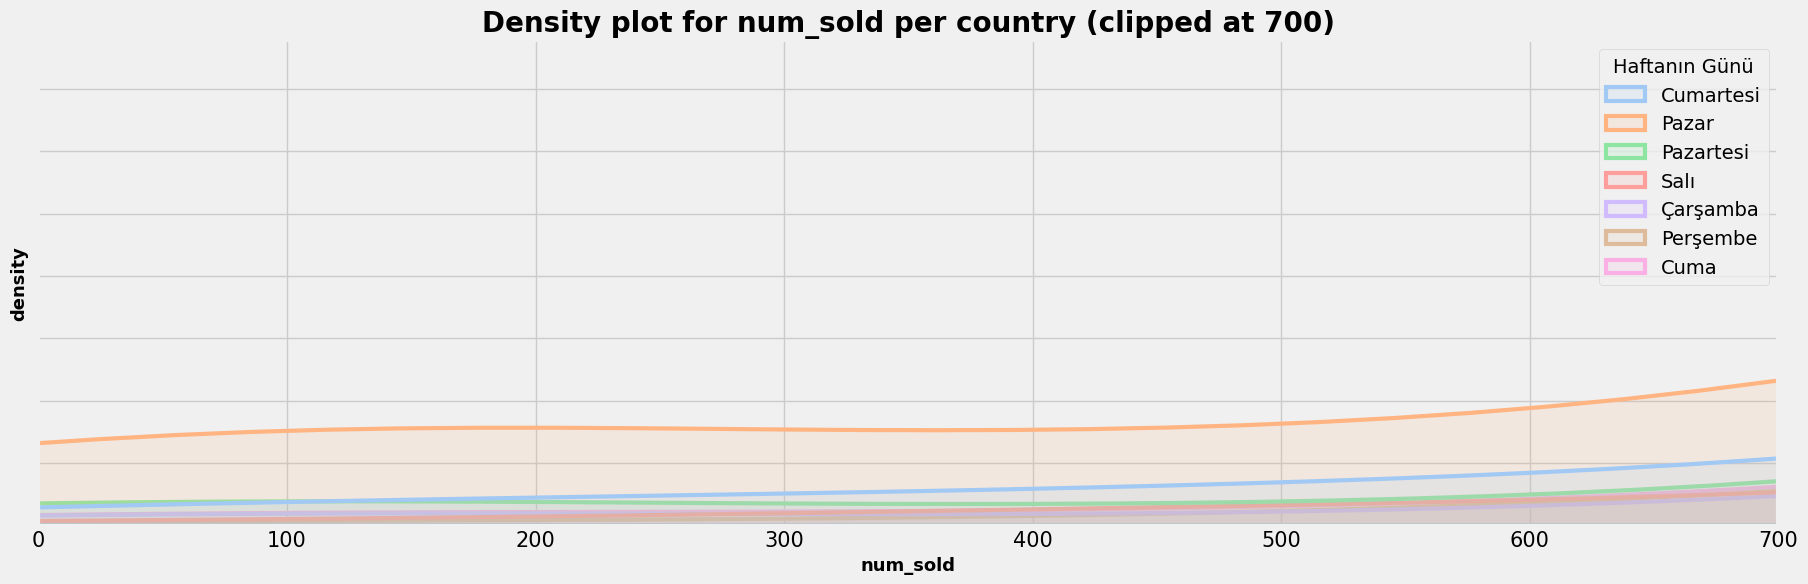

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=train, x = 'PTF (TL/MWh)', hue = 'Haftanın Günü', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for num_sold per country (clipped at 700)', fontweight = 'bold', fontsize = 20);

---

In [8]:
df_2023 = pd.read_excel('df_2023.xlsx')
df_2023.drop('ptf_tl_mwh.1', axis = 1 , inplace = True)
df_2023

,tarih,saat,yıl,ay,hafta,teklif_edilen_satış_miktarı_mwh,eşleşen_satış_miktarı_mwh,pozitif_dengesizlik_miktarı_mwh,negatif_dengesizlik_miktarı_mwh,rüzgar_üretim__tl_mwh,...,azami_fiyat_limiti_tl_mwh,teklif_edilen_alış_miktarı_mwh,ptf_tl_mwh,ptf_usd_mwh,gerçekleşen_tüketim_miktarımwh,ptf_eur_mwh,eşleşen_alış_miktarı_mwh,yük_tahmin_planı_mwh,haftanın_günü,ueçm_mwh
0,2023-01-01,00:00:00,2023,1,6,24715.9,16878.3,985.41,-962.06,1093.85,...,4200,20123.1,3999.99,213.92,28836.10,200.65,16878.2,25647,Pazar,26800.23
1,2023-01-01,01:00:00,2023,1,6,25001.4,16410.7,1249.59,-1158.00,1115.15,...,4200,19428.5,3500.00,187.18,27608.62,175.57,16410.8,24362,Pazar,25538.27
2,2023-01-01,02:00:00,2023,1,6,25543.4,16447.2,875.08,-1258.08,1178.79,...,4200,19418.5,2700.01,144.40,26347.75,135.44,16447.2,22943,Pazar,24293.66
3,2023-01-01,03:00:00,2023,1,6,25595.6,16202.5,991.86,-1013.36,1288.14,...,4200,19208.5,3500.00,187.18,25243.18,175.57,16202.5,21996,Pazar,23171.50
4,2023-01-01,04:00:00,2023,1,6,25430.5,15813.2,929.59,-969.95,1391.43,...,4200,18984.5,3999.98,213.92,24654.99,200.65,15813.2,21453,Pazar,22569.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9499,2024-01-31,19:00:00,2024,1,2,43979.2,31188.6,1018.01,-280.46,8091.34,...,2700,34848.0,2560.00,84.53,45675.64,78.05,31188.6,45844,Çarşamba,43124.11
9500,2024-01-31,20:00:00,2024,1,2,43444.3,30078.3,865.78,-308.24,7754.13,...,2700,33606.5,2350.00,77.60,44389.47,71.64,30078.2,44709,Çarşamba,41999.63
9501,2024-01-31,21:00:00,2024,1,2,43235.1,29102.4,416.77,-381.28,7312.31,...,2700,32585.6,2245.00,74.13,43201.72,68.44,29102.4,43308,Çarşamba,40806.42
9502,2024-01-31,22:00:00,2024,1,2,38718.1,25642.7,397.81,-502.98,6949.93,...,2700,28843.1,2253.64,74.41,41967.28,68.71,25642.7,41483,Çarşamba,39701.45


In [9]:
df_2023.columns

Index(['tarih', 'saat', 'yıl', 'ay', 'hafta',
       'teklif_edilen_satış_miktarı_mwh', 'eşleşen_satış_miktarı_mwh',
       'pozitif_dengesizlik_miktarı_mwh', 'negatif_dengesizlik_miktarı_mwh',
       'rüzgar_üretim__tl_mwh', 'güneş_üretim__tl_mwh', 'fiyat_limit_oranı',
       'i̇şlem_hacmi_tl', 'azami_fiyat_limiti_tl_mwh',
       'teklif_edilen_alış_miktarı_mwh', 'ptf_tl_mwh', 'ptf_usd_mwh',
       'gerçekleşen_tüketim_miktarımwh', 'ptf_eur_mwh',
       'eşleşen_alış_miktarı_mwh', 'yük_tahmin_planı_mwh', 'haftanın_günü',
       'ueçm_mwh'],
      dtype='object')

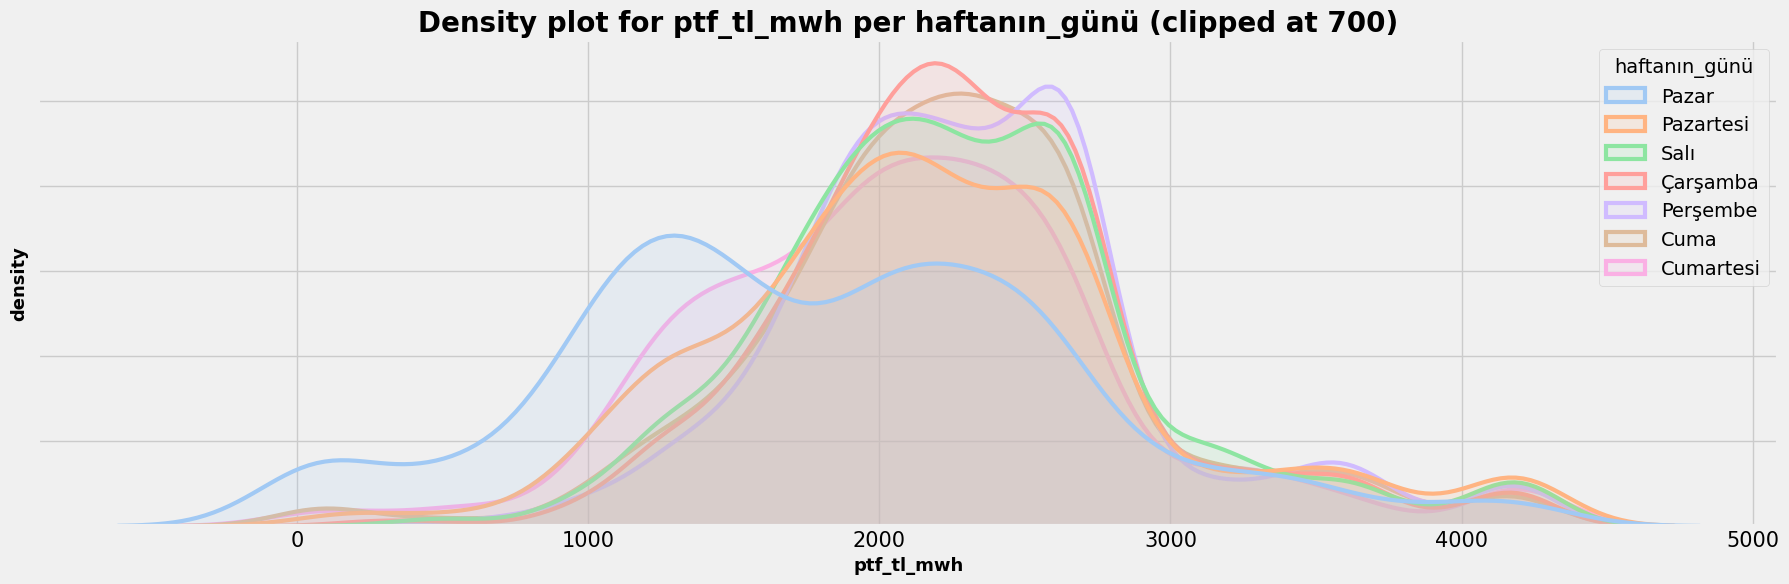

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=df_2023, x = 'ptf_tl_mwh', hue = 'haftanın_günü', fill=True, alpha = 0.15, ax = ax, linewidth=3, palette='pastel')
ax.set_xlabel('ptf_tl_mwh', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
# ax.set_xlim(0)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title('Density plot for ptf_tl_mwh per haftanın_günü (clipped at 700)', fontweight = 'bold', fontsize = 20);

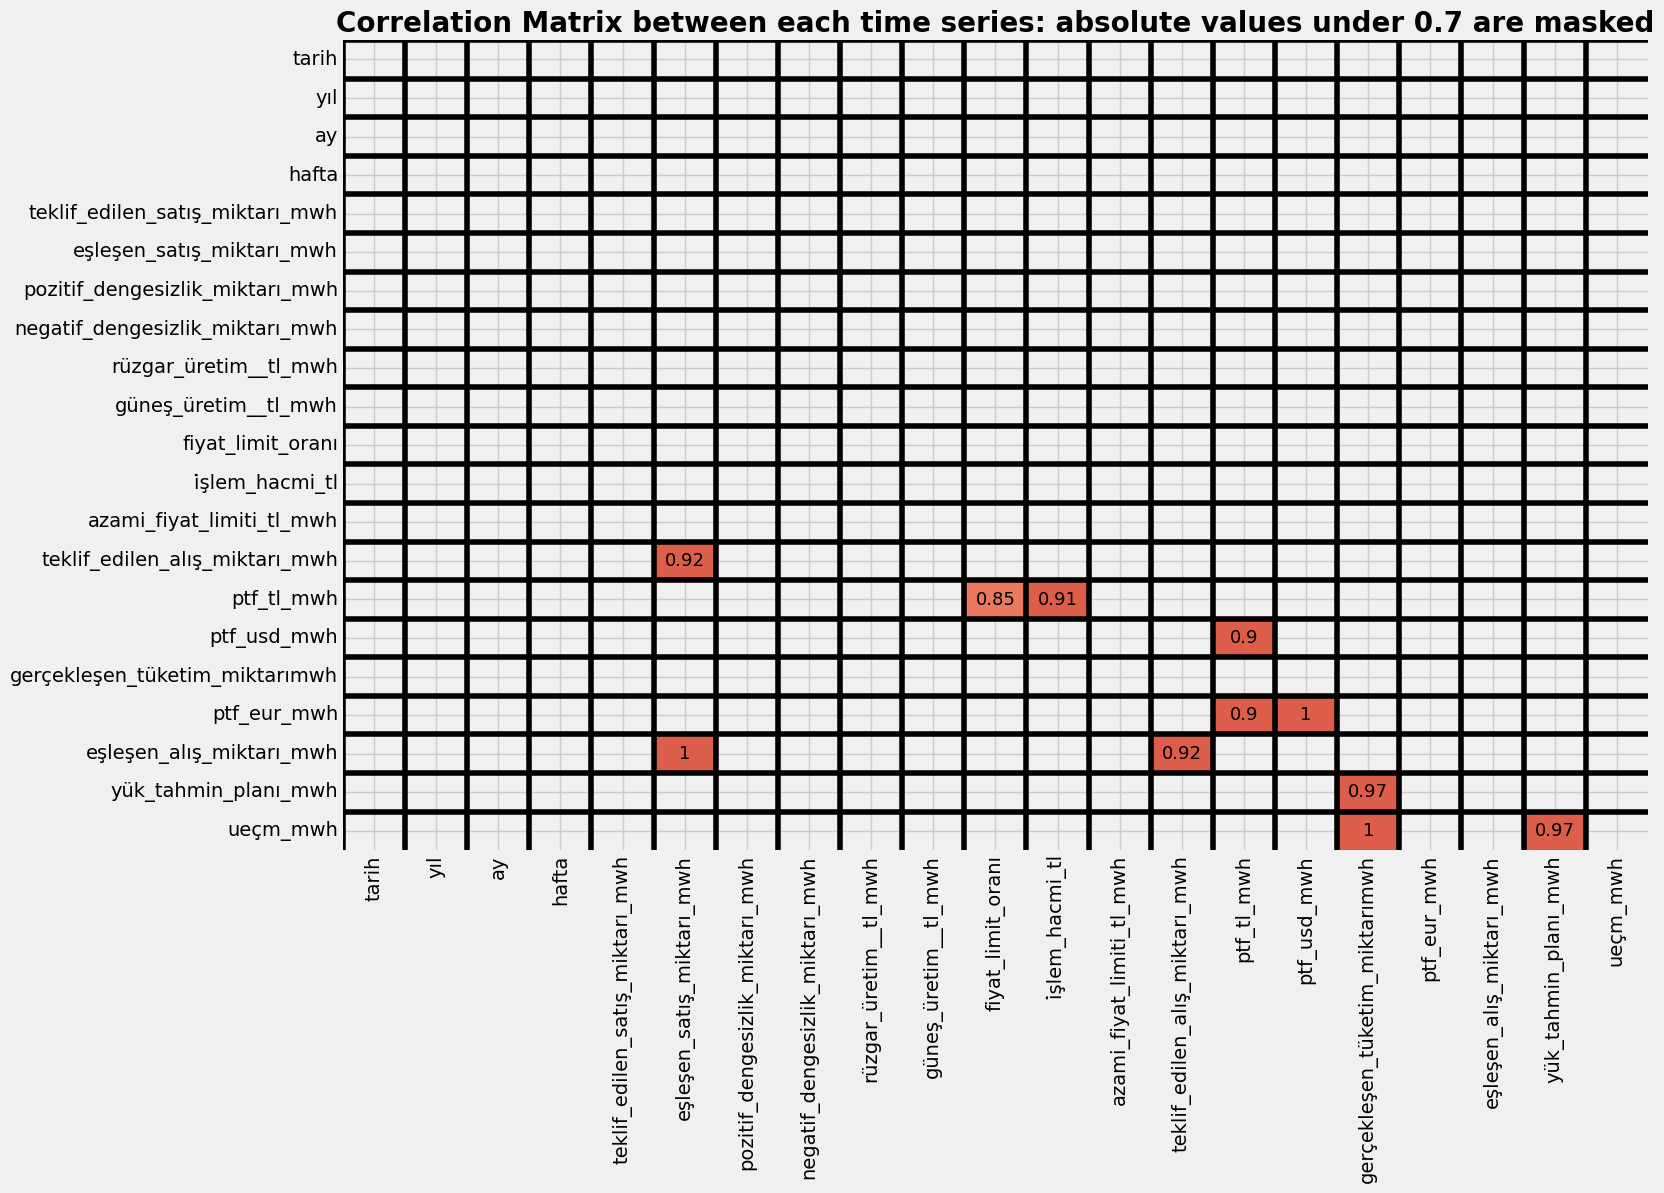

In [11]:
corr_matrix = df_2023.drop(['saat', 'haftanın_günü'], axis = 1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
colors = sns.color_palette('coolwarm', 16)
levels = np.linspace(-1, 1, 16)
cmap_plot, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend="max")

fig, ax = plt.subplots(1, 1, figsize = (15, 10))

mask_feature = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask = mask_feature | (np.abs(corr_matrix) < 0.85),
            annot=True, ax = ax, cbar=False,
            cmap = cmap_plot, 
            norm = norm, annot_kws={"size": 13, "color": 'black'
                                   # , 'fontweight' : 'bold'
                                   })

ax.hlines(range(corr_matrix.shape[1]), *ax.get_xlim(), color = 'black')
ax.vlines(range(corr_matrix.shape[1]), *ax.get_ylim(), color = 'black')

ax.set_title('Correlation Matrix between each time series: absolute values under 0.7 are masked', 
             fontsize = 20, color = 'black', fontweight = 'bold');


In [13]:
data = df_2023.reset_index().rename(columns = {'index' : 'time_idx' })
data.head()

,time_idx,tarih,saat,yıl,ay,hafta,teklif_edilen_satış_miktarı_mwh,eşleşen_satış_miktarı_mwh,pozitif_dengesizlik_miktarı_mwh,negatif_dengesizlik_miktarı_mwh,...,azami_fiyat_limiti_tl_mwh,teklif_edilen_alış_miktarı_mwh,ptf_tl_mwh,ptf_usd_mwh,gerçekleşen_tüketim_miktarımwh,ptf_eur_mwh,eşleşen_alış_miktarı_mwh,yük_tahmin_planı_mwh,haftanın_günü,ueçm_mwh
0,0,2023-01-01,00:00:00,2023,1,6,24715.9,16878.3,985.41,-962.06,...,4200,20123.1,3999.99,213.92,28836.10,200.65,16878.2,25647,Pazar,26800.23
1,1,2023-01-01,01:00:00,2023,1,6,25001.4,16410.7,1249.59,-1158.00,...,4200,19428.5,3500.00,187.18,27608.62,175.57,16410.8,24362,Pazar,25538.27
2,2,2023-01-01,02:00:00,2023,1,6,25543.4,16447.2,875.08,-1258.08,...,4200,19418.5,2700.01,144.40,26347.75,135.44,16447.2,22943,Pazar,24293.66
3,3,2023-01-01,03:00:00,2023,1,6,25595.6,16202.5,991.86,-1013.36,...,4200,19208.5,3500.00,187.18,25243.18,175.57,16202.5,21996,Pazar,23171.50
4,4,2023-01-01,04:00:00,2023,1,6,25430.5,15813.2,929.59,-969.95,...,4200,18984.5,3999.98,213.92,24654.99,200.65,15813.2,21453,Pazar,22569.44


In [15]:
data['yilin_haftasi'] = data['tarih'].dt.isocalendar().week.astype(str).astype('category')
data['haftanın_günü'] = data['haftanın_günü'].astype('category')
data["log_ptf_tl"] = np.log(data.ptf_tl_mwh + 1e-8)
data["avg_ptf_dayofweek"] = data.groupby(["time_idx", "haftanın_günü"],observed=True).ptf_tl_mwh.transform("mean")
data[['ptf_tl_mwh', 'avg_ptf_dayofweek']]

,ptf_tl_mwh,avg_ptf_dayofweek
0,3999.99,3999.99
1,3500.00,3500.00
2,2700.01,2700.01
3,3500.00,3500.00
4,3999.98,3999.98
...,...,...
9499,2560.00,2560.00
9500,2350.00,2350.00
9501,2245.00,2245.00
9502,2253.64,2253.64


In [16]:
holiday = pd.DataFrame(columns=['tarih', 'holiday'])
for date, name in sorted(holidays.Turkey(years=[2023,2024]).items()):
    holiday.loc[len(holiday)] = [date, name]
holiday['tarih'] = pd.to_datetime(holiday['tarih'], format='%Y-%m-%d', errors='ignore')
holiday

,tarih,holiday
0,2023-01-01,Yılbaşı
1,2023-04-21,Ramazan Bayramı
2,2023-04-22,Ramazan Bayramı
3,2023-04-23,Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bay...
4,2023-05-01,Emek ve Dayanışma Günü
5,2023-05-19,"Atatürk'ü Anma, Gençlik ve Spor Bayramı"
6,2023-06-28,Kurban Bayramı
7,2023-06-29,Kurban Bayramı
8,2023-06-30,Kurban Bayramı
9,2023-07-01,Kurban Bayramı


In [17]:
data['tarih'][0] == holiday['tarih'][0]

True

In [18]:
df = data.set_index('tarih').join(holiday.set_index('tarih')).reset_index()
df

,tarih,time_idx,saat,yıl,ay,hafta,teklif_edilen_satış_miktarı_mwh,eşleşen_satış_miktarı_mwh,pozitif_dengesizlik_miktarı_mwh,negatif_dengesizlik_miktarı_mwh,...,gerçekleşen_tüketim_miktarımwh,ptf_eur_mwh,eşleşen_alış_miktarı_mwh,yük_tahmin_planı_mwh,haftanın_günü,ueçm_mwh,yilin_haftasi,log_ptf_tl,avg_ptf_dayofweek,holiday
0,2023-01-01,0,00:00:00,2023,1,6,24715.9,16878.3,985.41,-962.06,...,28836.10,200.65,16878.2,25647,Pazar,26800.23,52,8.294047,3999.99,Yılbaşı
1,2023-01-01,1,01:00:00,2023,1,6,25001.4,16410.7,1249.59,-1158.00,...,27608.62,175.57,16410.8,24362,Pazar,25538.27,52,8.160518,3500.00,Yılbaşı
2,2023-01-01,2,02:00:00,2023,1,6,25543.4,16447.2,875.08,-1258.08,...,26347.75,135.44,16447.2,22943,Pazar,24293.66,52,7.901011,2700.01,Yılbaşı
3,2023-01-01,3,03:00:00,2023,1,6,25595.6,16202.5,991.86,-1013.36,...,25243.18,175.57,16202.5,21996,Pazar,23171.50,52,8.160518,3500.00,Yılbaşı
4,2023-01-01,4,04:00:00,2023,1,6,25430.5,15813.2,929.59,-969.95,...,24654.99,200.65,15813.2,21453,Pazar,22569.44,52,8.294045,3999.98,Yılbaşı
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9499,2024-01-31,9499,19:00:00,2024,1,2,43979.2,31188.6,1018.01,-280.46,...,45675.64,78.05,31188.6,45844,Çarşamba,43124.11,5,7.847763,2560.00,NaN
9500,2024-01-31,9500,20:00:00,2024,1,2,43444.3,30078.3,865.78,-308.24,...,44389.47,71.64,30078.2,44709,Çarşamba,41999.63,5,7.762171,2350.00,NaN
9501,2024-01-31,9501,21:00:00,2024,1,2,43235.1,29102.4,416.77,-381.28,...,43201.72,68.44,29102.4,43308,Çarşamba,40806.42,5,7.716461,2245.00,NaN
9502,2024-01-31,9502,22:00:00,2024,1,2,38718.1,25642.7,397.81,-502.98,...,41967.28,68.71,25642.7,41483,Çarşamba,39701.45,5,7.720302,2253.64,NaN


In [19]:
df['holiday'] = df['holiday'].astype(str)

df.loc[df['holiday'] != 'nan', 'holiday'] = True
df.loc[df['holiday'] == 'nan', 'holiday'] = False

n = df[df['tarih'].isin(pd.to_datetime(df['tarih'] + pd.DateOffset(day=1)))].index[0]
n2 = df[df['tarih'].isin(pd.to_datetime(df['tarih'] + pd.DateOffset(day=2)))].index[0]


df['is_holiday_lead_1'] = df['holiday'].shift(-n)
df['is_holiday_lead_2'] = df['holiday'].shift(-n2)
df['is_holiday_lag_1'] = df['holiday'].shift(n)
df['is_holiday_lag_2'] = df['holiday'].shift(n2)

df.loc[df['is_holiday_lead_1'].isnull(), 'is_holiday_lead_1' ] = False
df.loc[df['is_holiday_lead_2'].isnull(), 'is_holiday_lead_2' ] = False
df.loc[df['is_holiday_lag_1'].isnull(), 'is_holiday_lag_1' ] = False
df.loc[df['is_holiday_lag_2'].isnull(), 'is_holiday_lag_2' ] = False 



df.loc[df['holiday'] == 'nan', 'holiday'] = False


df

,tarih,time_idx,saat,yıl,ay,hafta,teklif_edilen_satış_miktarı_mwh,eşleşen_satış_miktarı_mwh,pozitif_dengesizlik_miktarı_mwh,negatif_dengesizlik_miktarı_mwh,...,haftanın_günü,ueçm_mwh,yilin_haftasi,log_ptf_tl,avg_ptf_dayofweek,holiday,is_holiday_lead_1,is_holiday_lead_2,is_holiday_lag_1,is_holiday_lag_2
0,2023-01-01,0,00:00:00,2023,1,6,24715.9,16878.3,985.41,-962.06,...,Pazar,26800.23,52,8.294047,3999.99,True,True,False,True,False
1,2023-01-01,1,01:00:00,2023,1,6,25001.4,16410.7,1249.59,-1158.00,...,Pazar,25538.27,52,8.160518,3500.00,True,True,False,True,False
2,2023-01-01,2,02:00:00,2023,1,6,25543.4,16447.2,875.08,-1258.08,...,Pazar,24293.66,52,7.901011,2700.01,True,True,False,True,False
3,2023-01-01,3,03:00:00,2023,1,6,25595.6,16202.5,991.86,-1013.36,...,Pazar,23171.50,52,8.160518,3500.00,True,True,False,True,False
4,2023-01-01,4,04:00:00,2023,1,6,25430.5,15813.2,929.59,-969.95,...,Pazar,22569.44,52,8.294045,3999.98,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9499,2024-01-31,9499,19:00:00,2024,1,2,43979.2,31188.6,1018.01,-280.46,...,Çarşamba,43124.11,5,7.847763,2560.00,False,False,False,False,False
9500,2024-01-31,9500,20:00:00,2024,1,2,43444.3,30078.3,865.78,-308.24,...,Çarşamba,41999.63,5,7.762171,2350.00,False,False,False,False,False
9501,2024-01-31,9501,21:00:00,2024,1,2,43235.1,29102.4,416.77,-381.28,...,Çarşamba,40806.42,5,7.716461,2245.00,False,False,False,False,False
9502,2024-01-31,9502,22:00:00,2024,1,2,38718.1,25642.7,397.81,-502.98,...,Çarşamba,39701.45,5,7.720302,2253.64,False,False,False,False,False


In [20]:
df['id'] = 'ptf'

In [21]:
split_date = '2024-01-01'
train = df[df['tarih'] < split_date]
test = df[df['tarih'] >= split_date]

max_prediction_length = 744
max_encoder_length = train['time_idx'].nunique()
training_cutoff = train['time_idx'].max() - max_prediction_length

In [22]:
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ptf_tl_mwh",
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["haftanın_günü"],
    time_varying_known_categoricals=["saat",'yilin_haftasi', "holiday",
                                     "is_holiday_lead_1", "is_holiday_lead_2",
                                     "is_holiday_lag_1", "is_holiday_lag_2"],
    #variable_groups={"is_holiday": ["is_holiday"]},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'ptf_tl_mwh','teklif_edilen_satış_miktarı_mwh', 'eşleşen_satış_miktarı_mwh',
       'pozitif_dengesizlik_miktarı_mwh', 'negatif_dengesizlik_miktarı_mwh',
       'rüzgar_üretim__tl_mwh', 'güneş_üretim__tl_mwh', 'fiyat_limit_oranı',
       'i̇şlem_hacmi_tl', 'azami_fiyat_limiti_tl_mwh',
       'teklif_edilen_alış_miktarı_mwh', 'ptf_usd_mwh',
       'gerçekleşen_tüketim_miktarımwh', 'ptf_eur_mwh',
       'eşleşen_alış_miktarı_mwh', 'yük_tahmin_planı_mwh',
       'ueçm_mwh','log_ptf_tl', 'avg_ptf_dayofweek'
    ],
    group_ids = ['id'],
    categorical_encoders={
        'yilin_haftasi':NaNLabelEncoder(add_nan=True)
    },
    lags={'ptf_tl_mwh': [168, 336]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [23]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

sm = SMAPE()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
print(f"Median loss for naive prediction on validation: {sm.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

Median loss for naive prediction on validation: 0.27149292826652527


In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor

In [ ]:
PATIENCE = 30
MAX_EPOCHS = 50
LEARNING_RATE = 0.1
OPTUNA = False

early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard



trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    devices=1, accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.25,
    limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)




tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=SMAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)

tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [28]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)